In [1]:
def def_wind_GFS_forecast(forecast_time, plot_map):

    import numpy as np
    import matplotlib.pyplot as plt
    import xarray as xr
    import os, glob
    from scipy.io import loadmat
    import pandas as pd 
    import datetime
    import utm
    import cfgrib


    n = 105
    
    time_0 = forecast_time 
    time = pd.date_range(time_0, periods=n, freq='3H')
    time_forecast = time.format(formatter=lambda x: x.strftime('%Y%m%d.%H%M'))

    paths_input= '/Volumes/Benitez/buoy_AU/noaa_forecast/noaa_wave_ensemble/ensemble_2021_11_07/wind_gfs/gfs_'
    time_paths = []
    time_p = time[0]
    
    nn=4

    for i in range(0,nn):
        a = time_p + datetime.timedelta(i)
        b = a.strftime('%Y%m%d')
        time_paths.append(paths_input+b)

    
    gfs = {}

    for t in range(0,nn):
        os.chdir(time_paths[t])
        if t < nn-1:
            prev_fore = sorted(glob.glob(os.path.join('gfs_forecast_*.grb2')))[:8]
            gfs["gfs"+str(t)] = xr.concat((xr.open_dataset(file, engine = 'cfgrib') for file in prev_fore),dim = 'time')
        else:
            prev_fore = sorted(glob.glob(os.path.join('gfs_forecast_*.grb2')))
            gfs["gfs"+str(t)] = xr.concat((xr.open_dataset(file, engine = 'cfgrib') for file in prev_fore),dim = 'time')

    gfs_forecast = xr.concat((gfs['gfs'+str(j)] for j in range(0,nn)), dim='time')    


    u_wind = gfs_forecast['u10'].values
    v_wind = gfs_forecast['v10'].values


    ## Escrevendo Vento input SWAN em STRING

    time_wind = 'gfs_forecast_'+forecast_time+'.wnd'

    paths_ouput = '/Volumes/Benitez/buoy_AU/noaa_forecast/noaa_wave_ensemble/ensemble_2021_11_07/wind_gfs/'
    os.chdir(paths_ouput)


    file = open(time_wind,'w')
    for t in range(len(time_forecast)):
        file.write(time_forecast[t])
        file.write('''
''')
        file.close()
        file = open(time_wind,'a+')
        file.write(pd.DataFrame(u_wind[t][:][:]).to_string(index=False, header=False, justify='justify', float_format='%7.3f'))
        file.write('''
''')
        file.write(pd.DataFrame(v_wind[t][:][:]).to_string(index=False, header=False, justify='justify', float_format='%7.3f'))
        file.write('''
''')
    
    file = open(time_wind,"rt")
    data = file.read()
    data = data.replace('NaN','0')
    file.close()
    file = open(time_wind,"wt")
    file.write(data)
    file.close()
   

    if plot_map:
        
        paths_map = '/Volumes/Benitez/buoy_AU/noaa_forecast/'
        os.chdir(paths_map)
        ## Carregando Grid do swan
        x = loadmat('grid_Au.mat')
        
        lon = gfs_forecast.longitude.values
        lat = gfs_forecast.latitude.values
        
        lat_swan = x['Yp'].T
        lon_swan = x['Xp'].T
        
        grid_utm = utm.from_latlon(lat,lon,56,'H')
        lat_gfs_utm = grid_utm[1]
        lon_gfs_utm = grid_utm[0]
        
        plt.contourf(lon_gfs_utm,lat_gfs_utm,gfs_forecast['u10'][17])
        plt.scatter(lon_swan,lat_swan)
        plt.scatter(lon_gfs_utm[0],lat_gfs_utm[0])
        print(lon_gfs_utm[0],lat_gfs_utm[0],lat.shape,lon.shape)

60877.58463941852 5782371.756590582 (33,) (33,)


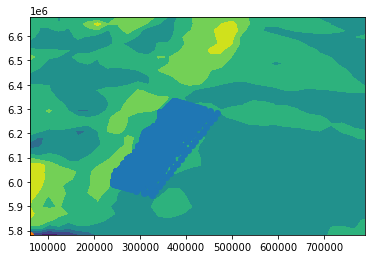

In [2]:
forecast_time = '20211203'
def_wind_GFS_forecast(forecast_time, True)

(33,)